<a href="https://colab.research.google.com/github/aleks-haksly/KarpovCources_Hard_DA_advanced/blob/main/03%20-%20Advanced%20experiments%20design/10_sprt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize, proportion_confint
from statsmodels.stats.power import NormalIndPower
import math
from tqdm.notebook import tqdm

In [ ]:
!wget https://raw.githubusercontent.com/aleks-haksly/AB_advanced/main/Part14%20-%20SPRT/Data/SPRT_homework_1.csv -q

In [ ]:
data = pd.read_csv("/content/SPRT_homework_1.csv")

## Задание 1 ##
Проведите базовый z-тест на пропорцию. Тест двусторонний.

Введите значение p-value в поле ниже с точностью до трех знаков в десятичной части.

In [ ]:
stat, pval = proportions_ztest([data.cont_conv_A.sum(), data.cont_conv_B.sum()], [data.cont_conv_A.count(), data.cont_conv_B.count()], alternative='two-sided')

In [ ]:
round(pval, 3)

0.024

## Задание 2 (1/2) ##
Проведите SPRT.

Параметры для проведения теста следующие:

alpha = 0.05
beta = 0.2
относительный mde = 0.05 от средней cont_conv_A в группе А


Укажите, какая гипотеза верна по мнению SPRT?
На каком размере выборки SPRT останавливается и делает вывод?

In [ ]:
alpha = 0.05
beta = 0.2
rel_mde = 0.05
mde_abs = data.cont_conv_A.mean() * rel_mde
mde_abs

0.00853090601185436

In [ ]:
data.head()

,cont_conv_A,cont_conv_B
0,0,0
1,0,0
2,1,0
3,1,0
4,0,0


In [ ]:
# создадим функцию проводящую тест на проверку гипотезы о равенстве долей с попощью SPRT
def get_decision_list_sprt_binom(values_A, values_B, alpha = 0.05, beta = 0.2, mde = 0.1):
    ''' Функция проводящая SPRT анализ для пропорций (долей, конверсий)
    values_A - массив значенений коверсии (0, 1) в группе А
    values_B - массив значенений коверсии (0, 1) в группе И
    alpha - уровень статзначимости, который выдерживает SPRT
    beta - уровень ошибки второго рода, который выдерживает SPRT
    mde - абсолютная разница между долями в двух группах, MDE проверяемый в SPRT

    return
    - early_stop_index: индекс на котором SPRT остановился и принял решение.
        Если по результатам всех наблюдений SPRT не смог принять решение возвращается len(data)
    - inference: какая гипотеза была принята по результатам SPRT
    - left_bound_list: массив границ для принятия решения. Длиной early_stop_index
    - right_bound_list: массив границ для принятия решения. Длиной early_stop_index
    - S_list: массив рассчитываемых значений отражающих изменение динамики разницы долей. Длиной early_stop_index
    - cum_diff_list: массив кумулятивной нарастающей разницы между долями в двух группах. Длиной early_stop_index
    '''
    min_len = int(np.mean([len(values_A), len(values_B)]))
    A = math.log(beta/(1 - alpha))
    B = math.log((1 - beta)/alpha)
    p = (values_A.mean() + values_B.mean())/2 # генеральная доля по двум выборкам

    left_bound_list = []
    right_bound_list = []
    S_list = []
    cum_diff_list = []

    for i in range(100, min_len):
        p0_i = np.mean(values_A[0:i])
        p1_i = np.mean(values_B[0:i])

        #p = (p0_i + p1_i)/2

        disp = p * (1 - p)
        diff = p1_i - p0_i
        left_bound = 2 * disp * A / mde
        right_bound = 2 * disp *  B / mde

        S = (i + 1) * (diff - mde/2)

        left_bound_list.append(left_bound)
        right_bound_list.append(right_bound)
        S_list.append(S)
        cum_diff_list.append(diff)

        if S < left_bound:
            return {'early_stop_index':i, 'inference':'Accept H0', 'left_bound_list': left_bound_list, 'right_bound_list': right_bound_list, 'S_list': S_list, 'cum_diff_list':cum_diff_list}
        if S > right_bound:
            return {'early_stop_index':i, 'inference':'Accept H1', 'left_bound_list': left_bound_list, 'right_bound_list': right_bound_list, 'S_list': S_list, 'cum_diff_list':cum_diff_list}
    return {'early_stop_index':i, 'inference':'Continue', 'left_bound_list': left_bound_list, 'right_bound_list': right_bound_list, 'S_list': S_list, 'cum_diff_list':cum_diff_list}

In [ ]:
inference_object  = get_decision_list_sprt_binom(data.cont_conv_A, data.cont_conv_B, alpha=alpha, beta=beta, mde=mde_abs)

Result: Accept H1
На каком наблюдении сделан вывод: 15314


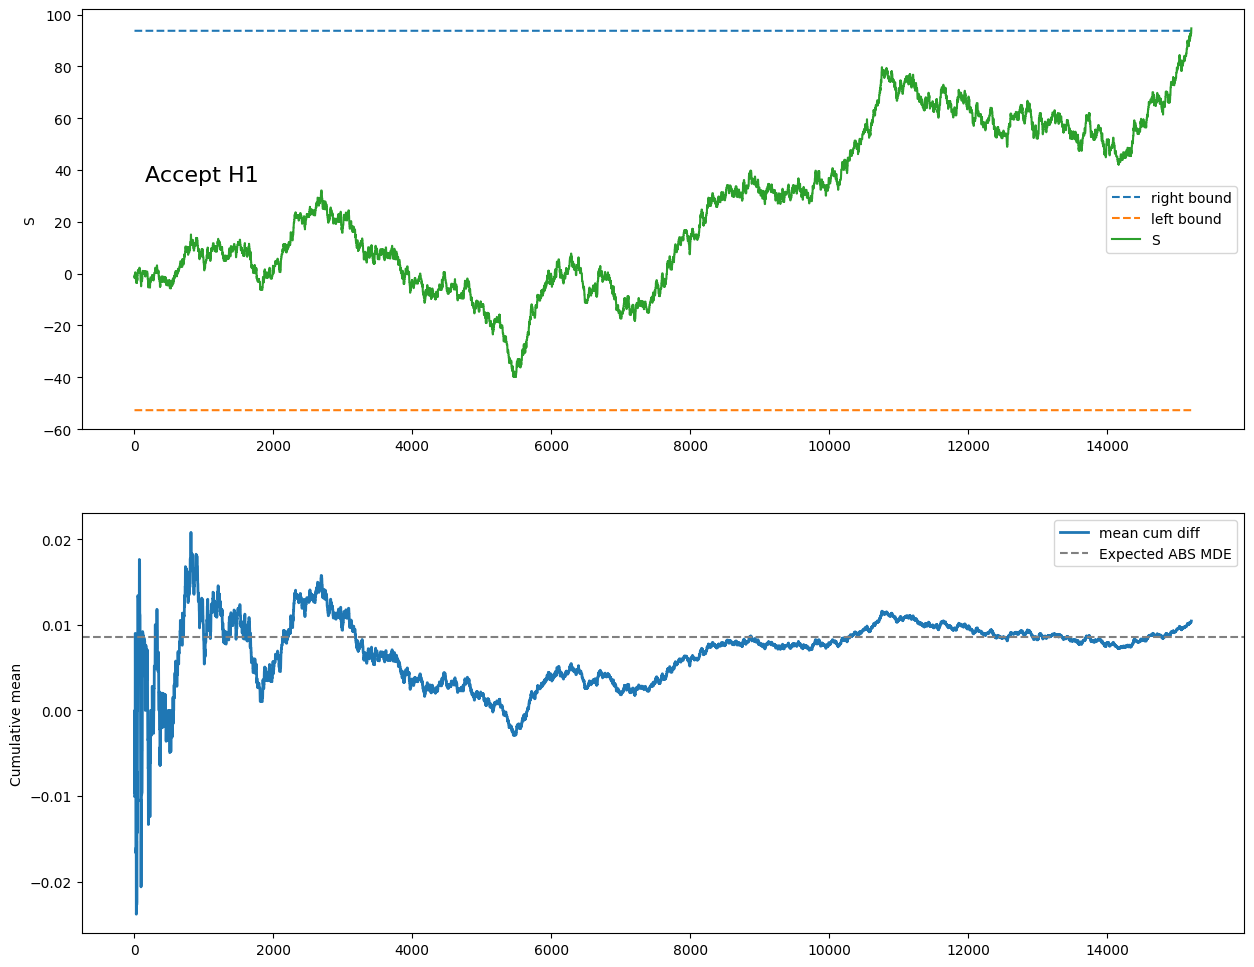

In [ ]:
print('Result:', inference_object['inference'])
print('На каком наблюдении сделан вывод:', inference_object['early_stop_index'])

fig, axes = plt.subplots(2, figsize=(15,12))

sns.lineplot(ax=axes[0], x = np.arange(1, len(inference_object['right_bound_list'])+1), y = inference_object['right_bound_list'], ls = '--', label='right bound')
sns.lineplot(ax=axes[0], x = np.arange(1, len(inference_object['left_bound_list'])+1), y = inference_object['left_bound_list'], ls = '--', label='left bound')
sns.lineplot(ax=axes[0], x = np.arange(1, len(inference_object['S_list'])+1), y = inference_object['S_list'], label='S')
axes[0].set_ylabel(ylabel = "S")
axes[0].text(y = np.quantile(inference_object['S_list'], 0.65), x = len(inference_object['S_list']) * 0.01, s = inference_object['inference'], fontsize = 16)
axes[0].legend()

sns.lineplot(ax=axes[1], x = np.arange(1, len(inference_object['right_bound_list'])+1), y = inference_object['cum_diff_list'], label='mean cum diff', linewidth=2)
axes[1].axhline(mde_abs, ls='--', color='gray', label = 'Expected ABS MDE')
axes[1].set_ylabel(ylabel = "Cumulative mean")
axes[1].legend();

## Задание 3 (1/4) ##
Найдите среднее время остановки (размер выборки) SPRT для текущих данных и сравните с Fixed Horizon.

В этом степе определим размер выборки, необходимый для Fixed Horizon.

Параметры дизайна

* относительный MDE = 0.05
* альфа = 0.05
* бета = 0.2
* гипотеза - двусторонняя
* пропорция в выборке 50/50
* исторические данные - данные по конверсии в группе А

In [ ]:
rel_mde = 0.05
alpha = 0.05
beta =0.2
alternative = 'two-sided'
ratio = 1

In [ ]:
p1 = data.cont_conv_A.mean()
p2 = p1 * (1 + rel_mde)
prop_effectsize = proportion_effectsize(p1, p2)

In [ ]:
sample_size = NormalIndPower().solve_power(effect_size = prop_effectsize, power = 1- beta, alpha = alpha, ratio = ratio)

In [ ]:
print(f"размер выборки, необходимый для Fixed Horizon = {sample_size:.0f}")

размер выборки, необходимый для Fixed Horizon = 31121


## Задание 3 (2/4) ##

В этом степе определим среднее время остановки для АА симуляций

## Задание 3 (3/4) ##
В этом степе определим среднее время остановки для АБ симуляций

Параметры симуляции те же, что и в предыдущем степе.

Параметры симуляции

* перед запуском указать np.random.seed(2)
* кол-во симуляций = 300
* для симуляции будем брать исторические данные многократно выборки кодом `np.random.choice(data['cont_conv_A'], size = len(data['cont_conv_A']))`. replace по умолчанию = True
*  размер выборок в симуляции = sample size с предыдущего шага
для получения требуемого ответа в цикле нужно делать обе симуляции одновременно (АА и АВ)

In [ ]:
nsim = 300
rel_mde = 0.05
fixed_horizon_sample_size = 31121
abs_effect = data.cont_conv_A.mean() * rel_mde


In [ ]:
aa_inference = []
ab_inference = []
np.random.seed(2)
for _ in tqdm(range(nsim)):
  a1_sample = np.random.choice(data['cont_conv_A'], size = fixed_horizon_sample_size)
  a2_sample = np.random.choice(data['cont_conv_A'], size = fixed_horizon_sample_size)
  b_sample = np.random.choice(data['cont_conv_B'], size = fixed_horizon_sample_size)
  aa_inference.append(get_decision_list_sprt_binom(a1_sample, a2_sample, mde = abs_effect))
  ab_inference.append(get_decision_list_sprt_binom(a1_sample, b_sample, mde = abs_effect))

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
aa_early_stop_indexes = round(np.mean([stop['early_stop_index'] for stop in aa_inference]))
ab_early_stop_indexes = round(np.mean([stop['early_stop_index'] for stop in ab_inference]))
print("среднее время остановки для АА симуляций = ", round(np.mean(aa_early_stop_indexes)))
print("среднее время остановки для АB симуляций = ", round(np.mean(ab_early_stop_indexes)))

среднее время остановки для АА симуляций =  10696
среднее время остановки для АB симуляций =  14547


## Задание 3 (4/4) ##
Оцените мощность SPRT методики на наших данных группы А и Б и относительном MDE = 0.05.

Параметры симуляции те же.

Введите значение в поле ниже с точностью до трех знаков в десятичной части.

In [ ]:
power = np.mean([1 if stop['inference'] == 'Accept H1' else 0 for stop in ab_inference])

In [ ]:
print(f"Мощность SPRT методики на наших данных группы А и Б = {power:.3f}")

Мощность SPRT методики на наших данных группы А и Б = 0.737


In [ ]:
power_CI_95 = proportion_confint(sum([1 if stop['inference'] == 'Accept H1' else 0 for stop in ab_inference]), len([1 if stop['inference'] == 'Accept H1' else 0 for stop in ab_inference]))
print("Power 95% CI:", power_CI_95)

Power 95% CI: (0.6868269125093385, 0.7865064208239949)
